# Clustering ML Repo
> Effect of embedding type and dimension on accuracy of clustering for classification tasks in ML Repo

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering must allow custom distance metric
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import pairwise_distances
from util import cluster, mixture_embedding

# Label tokens
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, accuracy_score

INFO: Using numpy backend


In [48]:
def load_task(dd, subdir, **embed_kwargs) -> (pd.DataFrame, pd.DataFrame):
    # name = data_path.split("/")[-1]
    data_path = f"{dd}/{subdir}"
    # Get OTU table
    otu_path = f"{data_path}/{subdir}_otus.txt"
    otu_table = pd.read_table(otu_path, index_col=0).T
    otu_table = otu_table / otu_table.sum()
    X = otu_table

    # Tokenize labels
    labels_path = f"{data_path}/{subdir}_labels.txt"
    labels = pd.read_table(labels_path, index_col=0)
    if "ControlVar" in labels.columns:
        labels = labels.drop("ControlVar", axis=1)
    label_encoder = OrdinalEncoder()
    label_encoder.fit(labels)
    y = label_encoder.transform(labels)
    if y.shape[1] == 1:
        y = y.ravel()
    y = pd.Series(y, index=labels.index)

    # Ensure agreement:
    shared_samples = X.index.intersection(y.index)
    X = X.loc[shared_samples]
    y = y.loc[shared_samples]

    return X, y

def experiment(X, y, euc_embeddings, hyp_embeddings):
    """For a dataset and a known dimensionality, get cluster scores"""
    hyp_dim = hyp_embeddings.shape[1]
    euc_dim = euc_embeddings.shape[1]
    assert hyp_dim == euc_dim

    pca_dim = np.min([hyp_dim, X.shape[0]])

    X_raw = X.copy()
    X_pca = PCA(n_components=pca_dim).fit_transform(X)
    X_euc = mixture_embedding(X, euc_embeddings, geometry="euclidean")
    X_hyp = mixture_embedding(X, hyp_embeddings, geometry="hyperbolic")

    # Cluster
    # out_df = pd.DataFrame(columns=["name", "dim", "type", "ARI", "accuracy"])
    out = []
    for X, name in zip([X_raw, X_pca, X_euc, X_hyp], ["raw", "pca", "euc", "hyp"]):
        _, y_pred = cluster(X, n_clusters=2, labels=y)
        # print(name, "Y SHAPES:", y_pred.shape, y.shape)

        out.append({
            "dim": hyp_dim,
            "type": name,
            "ARI": adjusted_rand_score(y_pred, y),
            "accuracy": accuracy_score(y_pred, y)
        })

    return out

import os

dd = "../../data/interim/mlrepo_clean/classification/"
big_df = pd.DataFrame(columns=["name", "dim", "type", "ARI", "accuracy"])
for embed_dim in [16, 128]:
    # Get embeddings
    euc_embeddings = pd.read_csv(
        f"~/DATA/otu_embeddings/embeddings_euclidean_{embed_dim}.csv", 
        index_col=0
    )
    hyp_embeddings = pd.read_csv(
        f"~/DATA/otu_embeddings/embeddings_hyperbolic_{embed_dim}.csv", 
        index_col=0
    )

    for subdir in os.listdir(dd):
        # Get data
        X, y = load_task(dd, subdir)

        # Run experiment
        # Pandas 2.0 does not support appending:
        out_df = pd.DataFrame(
            experiment(X, y, euc_embeddings, hyp_embeddings)
        )
        out_df["name"] = subdir
        big_df = pd.concat([big_df, out_df])
        # except Exception as e:
        #     print(e)
        #     continue

big_df.to_csv("../../data/processed/mlrepo_scores.csv")

<Axes: title={'center': 'accuracy'}, xlabel='[type, dim]'>

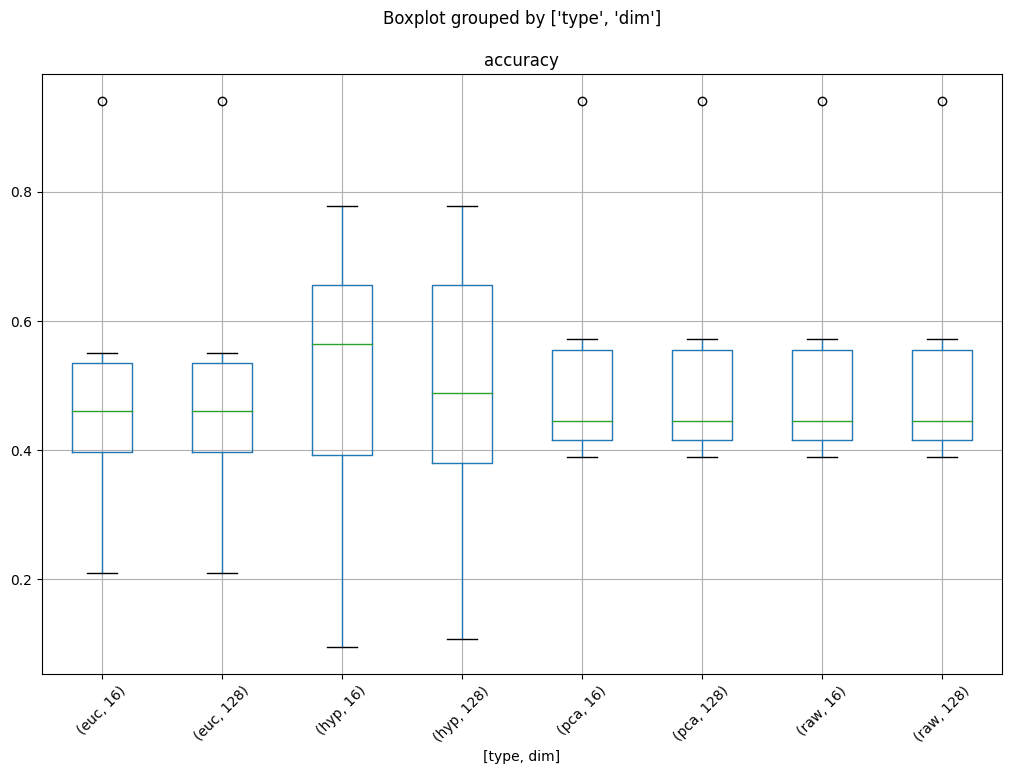

In [47]:
# Plot 8 boxplots on same figure

big_df.boxplot(
    column="accuracy", by=["type", "dim"], figsize=(12, 8), rot=45
)

<Axes: title={'center': 'ARI'}, xlabel='[type, dim]'>

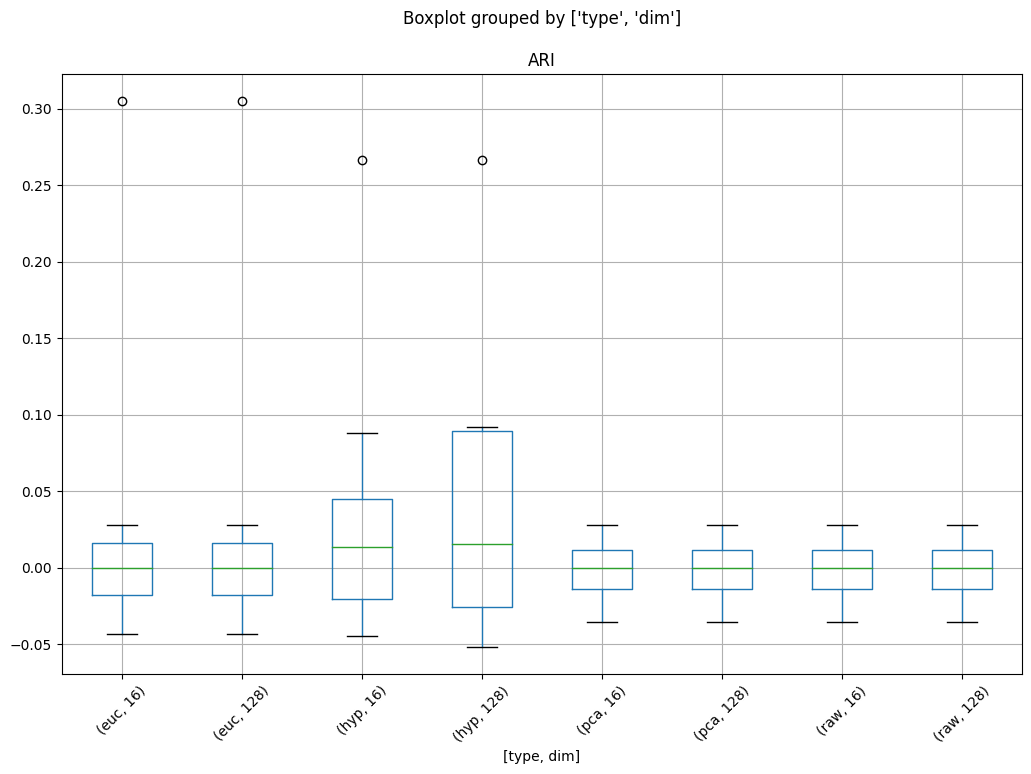

In [49]:
# Plot 8 boxplots on same figure

big_df.boxplot(
    column="ARI", by=["type", "dim"], figsize=(12, 8), rot=45
)